### This is the first version of 4 classfication models with selected important features based on experience and without dropping LOS outlier with 'DRG PROGRAM' grouped.

In [1]:
# IMPORT MODULES

import os
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV,KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
# from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from mlxtend.plotting import plot_learning_curves
from mlxtend.preprocessing import shuffle_arrays_unison


In [3]:
data = pd.read_excel('../datafest/TC_DeID_data_1000.xlsx')
print("With id", data.shape)
data_full = data.drop('TC_ID', 1)
print("No id",data_full.shape)

With id (1000, 21)
No id (1000, 20)


In [4]:
df_los = data_full.dropna(subset=['LOS'])
df_los

,request status,Transfer Referral Source,Transfer Back Agreement,LOA (Mark X if Yes),Accepting Physician Specialty,Required Level Of Care,RequestedTreatmentIntervention,FromWherePatientAdmittedtoReferringFacility,InfectionPrecaution,Patient Status,EMTALA Y/N(Patient Status Details),SpecialConsiderations,Gender,DRG PROGRAM,PAYOR,LOS,ICU LOS,LOS Outlier,Discharge Disposition,Age
5,accepted,"Presbyterian Intercommunity (PIH), Whittier",True,False,NEUROLOGY-STROKE,Med/Surg,Medical management/optimization,NaN,NaN,Inpatient,NaN,NaN,Male,Lymphoma,Medicare Managed Care,6.0,3.0,NaN,ACUTE-ANOTHER HOSP,56
10,accepted,Norris Cancer Hospital,False,False,"SURGERY, TRAUMA",ICU,Surgical evaluation/surgery,NaN,NaN,Inpatient,NaN,NaN,Female,Infectious Disease,Managed Exchange,2.0,2.0,NaN,EXPIRED,53
13,accepted,Kaweah Delta,False,True,"SURGERY, NEUROLO",Stepdown,NaN,NaN,NaN,Inpatient,NaN,NaN,Male,Craniotomy,Medicaid Managed Care,41.0,6.0,outlier,ACUTE-ANOTHER HOSP,58
14,accepted,Antelope Valley Hospital,True,False,GASTROENTEROLOGY - TRANSPLANT HEPATOLOGY,Telemetry,Medical management/optimization,Home,NaN,Inpatient,NaN,NaN,Male,Hepatobiliary Disorders,Medicare,44.0,22.0,outlier,ACUTE-ANOTHER HOSP,63
15,accepted,"Presbyterian Intercommunity (PIH), Whittier",True,False,"SURGERY, CARDIOVA",Telemetry,NaN,NaN,NaN,Inpatient,NaN,NaN,Male,Cardiac Surgical Ablation,Medicaid,10.0,1.0,NaN,ACUTE-ANOTHER HOSP,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,accepted,Glendale Adventist,False,False,"SURGERY, GENERAL",Stepdown,Surgical evaluation/surgery,NaN,NaN,NaN,NaN,NaN,NaN,Other GI Medicine,Medicare,5.0,0.0,NaN,HOME HEALTH ORG,52
989,accepted,Valley Presbyterian,True,False,INTERNAL MEDICIN- HOSPITALIST,Telemetry,Surgical evaluation/surgery,ER,NaN,Inpatient,NaN,NaN,Female,Other GI Medicine,Medicaid Managed Care,6.0,0.0,outlier,HOME/SELF CARE,63
991,accepted,Verdugo Hills,False,False,CARDIOLOGY,Stepdown,NaN,NaN,NaN,ER,NaN,NaN,Female,Percutaneous Cardiac Procedures,Medicare,2.0,0.0,NaN,HOME/SELF CARE,75
995,accepted,County LAC USC,True,False,"SURGERY, ORTHOPE",Med/Surg,Surgical evaluation/surgery,Home,Immuno compromised,Inpatient,NaN,NaN,Female,Fracture/Injury,Medicare,5.0,0.0,NaN,HOME HEALTH ORG,46


tensorflow not supported for python 3.8

In [5]:
data_full.info()
data_full.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   request status                               1000 non-null   object 
 1   Transfer Referral Source                     1000 non-null   object 
 2   Transfer Back Agreement                      1000 non-null   bool   
 3   LOA (Mark X if Yes)                          1000 non-null   bool   
 4   Accepting Physician Specialty                733 non-null    object 
 5   Required Level Of Care                       647 non-null    object 
 6   RequestedTreatmentIntervention               360 non-null    object 
 7   FromWherePatientAdmittedtoReferringFacility  308 non-null    object 
 8   InfectionPrecaution                          64 non-null     object 
 9   Patient Status                               573 non-null    object 
 10  E

,LOS,ICU LOS
count,330.000000,330.000000
mean,10.042424,3.475758
std,13.902768,10.445736
min,1.000000,0.000000
25%,3.000000,0.000000
50%,6.000000,0.000000
75%,11.000000,2.750000
max,132.000000,132.000000


In [6]:
data_full.head(5)

,request status,Transfer Referral Source,Transfer Back Agreement,LOA (Mark X if Yes),Accepting Physician Specialty,Required Level Of Care,RequestedTreatmentIntervention,FromWherePatientAdmittedtoReferringFacility,InfectionPrecaution,Patient Status,EMTALA Y/N(Patient Status Details),SpecialConsiderations,Gender,DRG PROGRAM,PAYOR,LOS,ICU LOS,LOS Outlier,Discharge Disposition,Age
0,declined,Gardena Memorial,False,False,NaN,Med/Surg,NaN,NaN,NaN,ER,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,accepted,Mercy Bakersfield,True,False,"SURGERY, COLORECTAL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,78
2,declined,Kaweah Delta,False,False,NaN,Med/Surg,Medical management/optimization,Home,NaN,Inpatient,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,declined,Valley Presbyterian,False,False,"SURGERY, GENERAL- BARIATRIC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,declined,"Inter-Community, Citrus Valley",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Label = LOS
# the attributes that is NOT related to LOS
y = df_los['LOS']
X = df_los.drop('LOS', 1)
X = X.drop('LOA (Mark X if Yes)', 1)
X = X.drop('FromWherePatientAdmittedtoReferringFacility', 1)
X = X.drop('EMTALA Y/N(Patient Status Details)', 1)
X = X.drop('SpecialConsiderations', 1)
X = X.drop('Transfer Back Agreement', 1)
X = X.drop('Transfer Referral Source', 1)
X = X.drop('InfectionPrecaution',1)
X = X.drop('request status',1)

print("y - Labels", y.shape)
print("X - No Label No id ", X.shape)
print(X.columns)

y - Labels (330,)
X - No Label No id  (330, 11)
Index(['Accepting Physician Specialty', 'Required Level Of Care',
       'RequestedTreatmentIntervention', 'Patient Status', 'Gender',
       'DRG PROGRAM', 'PAYOR', 'ICU LOS', 'LOS Outlier',
       'Discharge Disposition', 'Age'],
      dtype='object')


Based on discussion, the features and attributes that we care most are Patient Status, DRG PROGRAM, LOS Outlier, Discharge Disposition and Age. let's see how each of them distributed. 

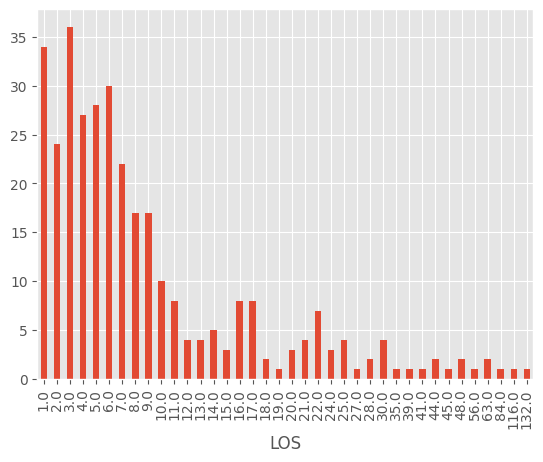

In [8]:
df_los.groupby('LOS').size().plot.bar()
plt.show()

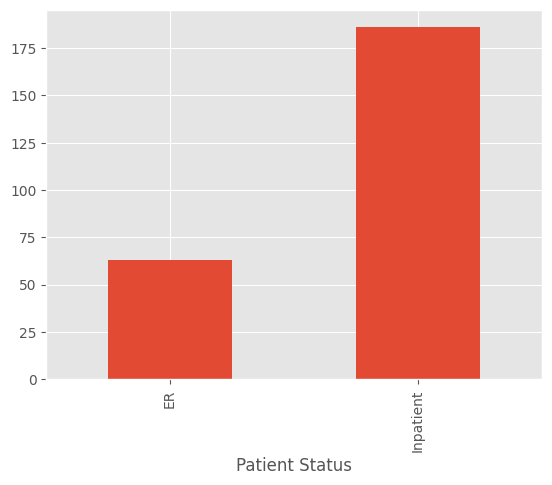

In [9]:
df_los.groupby('Patient Status').size().plot.bar()
plt.show()

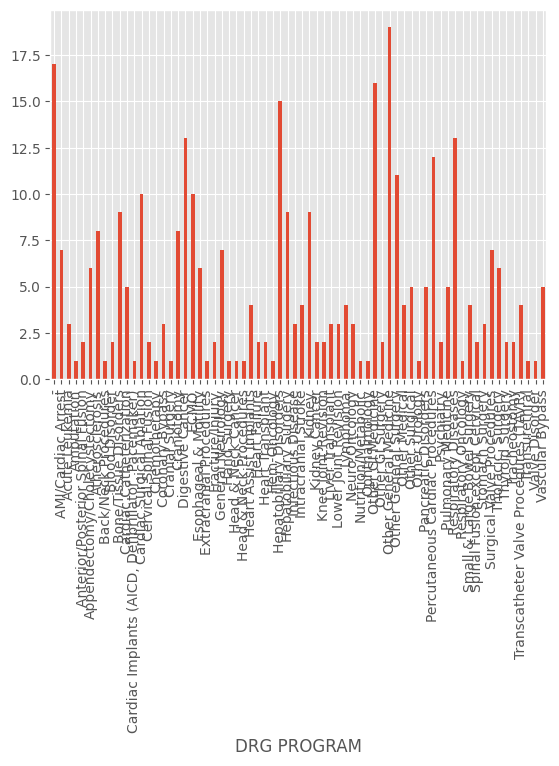

In [10]:
df_los.groupby('DRG PROGRAM').size().plot.bar()
plt.show()

#### Group the lower portion of categories of 'DRG PROGRAM' to one bigger categories

In [11]:
total = df_los['DRG PROGRAM'].count()
value_counts = df_los['DRG PROGRAM'].value_counts(normalize=True)
df_counts = pd.DataFrame({'value': value_counts.index, 'count': value_counts.values})
df_counts['portion'] = df_counts['count'].apply(lambda x: x/total)
df_counts = df_counts.sort_values(by='portion', ascending=False)
df_counts

,value,count,portion
0,Other General Medicine,0.057576,0.000174
1,-,0.051515,0.000156
2,Other GI Medicine,0.048485,0.000147
3,Hepatobiliary Disorders,0.045455,0.000138
4,Digestive Cancer,0.039394,0.000119
...,...,...,...
56,Head & Neck Cancer,0.003030,0.000009
55,Chemotherapy,0.003030,0.000009
54,Other Urology,0.003030,0.000009
53,Amputation,0.003030,0.000009


In [12]:
counts = df_los['DRG PROGRAM'].value_counts().sort_values(ascending=False)
threshold = counts.quantile(0.8)
df_los['DRG PROGRAM'] = [x if counts[x] >= threshold and x != '-' else 'Other' for x in df_los['DRG PROGRAM']]
df_los['DRG PROGRAM']


5                                Other
10                               Other
13                          Craniotomy
14             Hepatobiliary Disorders
15           Cardiac Surgical Ablation
                    ...               
986                  Other GI Medicine
989                  Other GI Medicine
991    Percutaneous Cardiac Procedures
995                              Other
998              Hepatobiliary Surgery
Name: DRG PROGRAM, Length: 330, dtype: object

In [13]:
counts = df_los['DRG PROGRAM'].value_counts().sort_values(ascending=False)
counts

Other                              168
Other General Medicine              19
Other GI Medicine                   16
Hepatobiliary Disorders             15
Digestive Cancer                    13
Respiratory Diseases                13
Percutaneous Cardiac Procedures     12
Other General Surgery               11
Cardiac Surgical Ablation           10
ECMO                                10
Kidney                               9
Hepatobiliary Surgery                9
Bone/Tissue Disorders                9
Craniotomy                           8
Atherosclerosis                      8
Name: DRG PROGRAM, dtype: int64

#### If drg program exist then outlier, >15 then outlier, it's binary variable. 

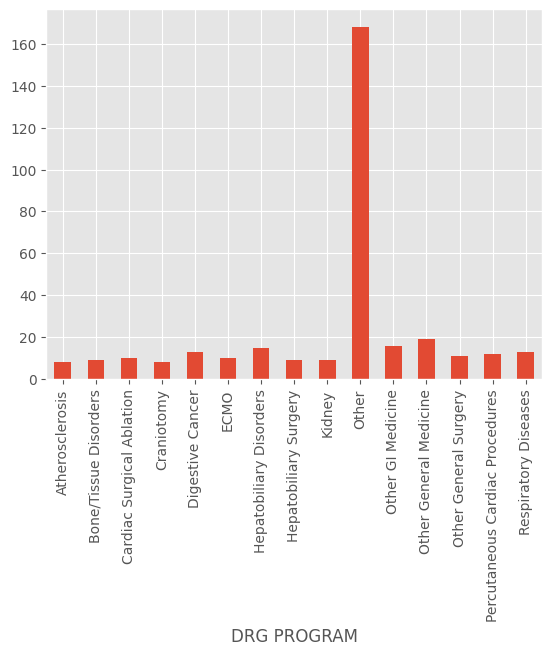

In [16]:
df_los.groupby('DRG PROGRAM').size().plot.bar()
plt.show()

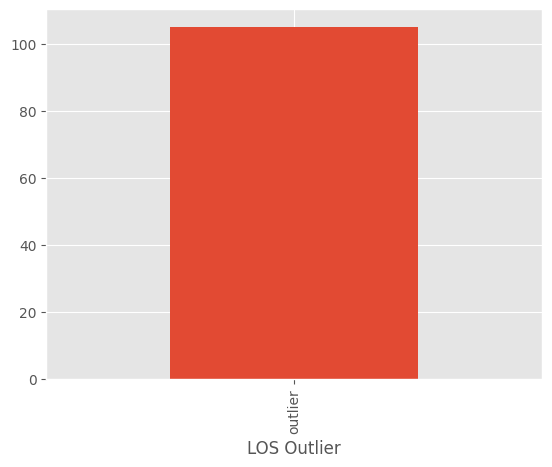

In [14]:
df_los.groupby('LOS Outlier').size().plot.bar()
plt.show()

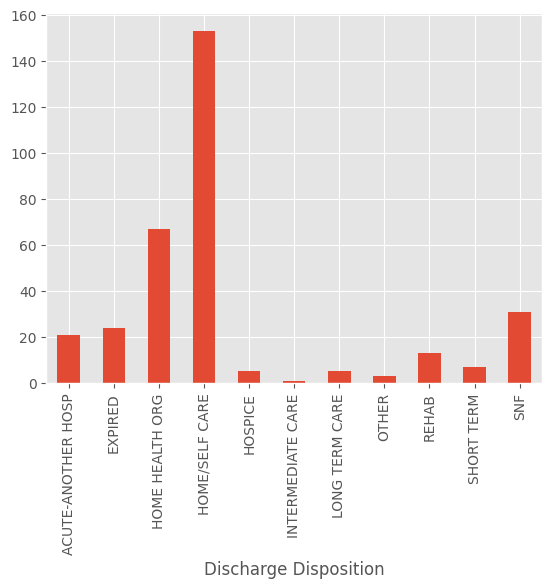

In [15]:
df_los.groupby('Discharge Disposition').size().plot.bar()
plt.show()

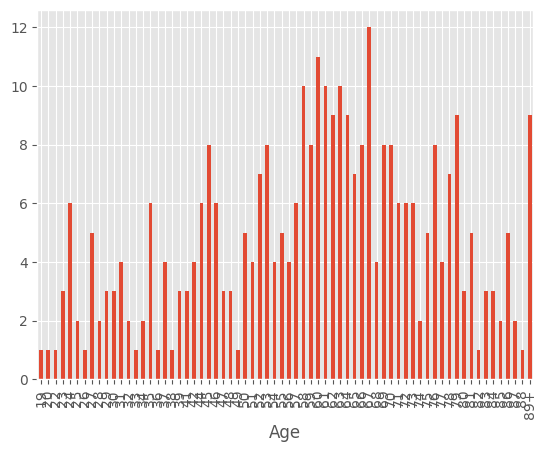

In [17]:
df_los.groupby('Age').size().plot.bar()
plt.show()

#### Patient Status, DRG PROGRAM, LOS Outlier, Discharge Disposition are all categorical features, it's necessary to convert categorical features to numerical. I use one-hot-encoding here

In [18]:
#                     
categorical_columns = [
                    'DRG PROGRAM',
                    'Patient Status',                     
                    'LOS Outlier',
                    'Discharge Disposition'
                      ]
for col in categorical_columns:
    #if the original column is present replace it with a one-hot
    if col in X.columns:
        one_hot_encoded = pd.get_dummies(X[col])
        X = X.drop(col, axis=1)
        X = X.join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
        
print(X.shape)

(330, 89)


In [19]:
#                     
categorical_columns = [
                    'DRG PROGRAM',
                    'Patient Status',                     
                    'LOS Outlier',
                    'Discharge Disposition'
                      ]
for col in categorical_columns:
    #if the original column is present replace it with a one-hot
    if col in df_los.columns:
        one_hot_encoded = pd.get_dummies(df_los[col])
        df_los = df_los.drop(col, axis=1)
        df_los = df_los.join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
        
print(df_los.shape)

(330, 45)


In [57]:
print(df_los.shape)
print(X.shape)
#XnotNorm = np.array(X.copy())
XnotNorm = df_los.copy()
print('XnotNorm ', XnotNorm.shape)

ynotNorm = y.copy()
print('ynotNorm ', ynotNorm.shape)

(330, 45)
(330, 89)
XnotNorm  (330, 45)
ynotNorm  (330,)


In [58]:
XnotNorm = XnotNorm.drop('Accepting Physician Specialty',1)
XnotNorm = XnotNorm.drop('Required Level Of Care',1)
XnotNorm = XnotNorm.drop('RequestedTreatmentIntervention',1)
XnotNorm = XnotNorm.drop('Gender',1)
XnotNorm = XnotNorm.drop('PAYOR',1)
XnotNorm = XnotNorm.drop('LOA (Mark X if Yes)', 1)
XnotNorm = XnotNorm.drop('FromWherePatientAdmittedtoReferringFacility', 1)
XnotNorm = XnotNorm.drop('EMTALA Y/N(Patient Status Details)', 1)
XnotNorm = XnotNorm.drop('SpecialConsiderations', 1)
XnotNorm = XnotNorm.drop('Transfer Back Agreement', 1)
XnotNorm = XnotNorm.drop('Transfer Referral Source', 1)
XnotNorm = XnotNorm.drop('InfectionPrecaution',1)
XnotNorm = XnotNorm.drop('request status',1)
XnotNorm = XnotNorm.drop('LOS',1)
XnotNorm = XnotNorm.drop('ICU LOS',1)
# XnotNorm = XnotNorm.drop('DRG PROGRAM',1)
# XnotNorm = XnotNorm.drop('PAYOR',1)
XnotNorm.columns


Index(['Age', 'Atherosclerosis', 'Bone/Tissue Disorders',
       'Cardiac Surgical Ablation', 'Craniotomy', 'Digestive Cancer', 'ECMO',
       'Hepatobiliary Disorders', 'Hepatobiliary Surgery', 'Kidney', 'Other',
       'Other GI Medicine', 'Other General Medicine', 'Other General Surgery',
       'Percutaneous Cardiac Procedures', 'Respiratory Diseases', 'ER',
       'Inpatient', 'outlier', 'ACUTE-ANOTHER HOSP', 'EXPIRED',
       'HOME HEALTH ORG', 'HOME/SELF CARE', 'HOSPICE', 'INTERMEDIATE CARE',
       'LONG TERM CARE', 'OTHER', 'REHAB', 'SHORT TERM', 'SNF'],
      dtype='object')

In [59]:
ynotNorm

5       6.0
10      2.0
13     41.0
14     44.0
15     10.0
       ... 
986     5.0
989     6.0
991     2.0
995     5.0
998    22.0
Name: LOS, Length: 330, dtype: float64

##### Clean data

In [60]:
XnotNorm.replace('Unknown', pd.np.nan, inplace=True)
XnotNorm.replace('89+', 90, inplace=True)

Normalize X

In [61]:
x = XnotNorm.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
XNorm = pd.DataFrame(x_scaled, columns=XnotNorm.columns)
#print(XNorm)
#print(y)
print('X normalized')

X normalized


In [62]:
XNorm.columns = XNorm.columns.astype(str) 
XNorm

,Age,Atherosclerosis,Bone/Tissue Disorders,Cardiac Surgical Ablation,Craniotomy,Digestive Cancer,ECMO,Hepatobiliary Disorders,Hepatobiliary Surgery,Kidney,...,EXPIRED,HOME HEALTH ORG,HOME/SELF CARE,HOSPICE,INTERMEDIATE CARE,LONG TERM CARE,OTHER,REHAB,SHORT TERM,SNF
0,-0.194641,-0.157622,-0.167444,-0.176777,-0.157622,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,-0.280056,-0.504730,-0.929735,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
1,-0.365168,-0.157622,-0.167444,-0.176777,-0.157622,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,3.570714,-0.504730,-0.929735,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
2,-0.080957,-0.157622,-0.167444,-0.176777,6.344289,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,-0.280056,-0.504730,-0.929735,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
3,0.203254,-0.157622,-0.167444,-0.176777,-0.157622,-0.202508,-0.176777,4.582576,-0.167444,-0.167444,...,-0.280056,-0.504730,-0.929735,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
4,-1.388326,-0.157622,-0.167444,5.656854,-0.157622,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,-0.280056,-0.504730,-0.929735,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,-0.422010,-0.157622,-0.167444,-0.176777,-0.157622,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,-0.280056,1.981255,-0.929735,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
326,0.203254,-0.157622,-0.167444,-0.176777,-0.157622,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,-0.280056,-0.504730,1.075576,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
327,0.885360,-0.157622,-0.167444,-0.176777,-0.157622,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,-0.280056,-0.504730,1.075576,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992
328,-0.763063,-0.157622,-0.167444,-0.176777,-0.157622,-0.202508,-0.176777,-0.218218,-0.167444,-0.167444,...,-0.280056,1.981255,-0.929735,-0.124035,-0.055132,-0.124035,-0.095783,-0.202508,-0.147214,-0.321992


RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.
HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively.

In [63]:
# Fill in missing values with imputation of mean
# imputer = SimpleImputer(strategy='mean')
# X = imputer.fit_transform(XNorm.drop(['Age'], axis=1))
# y = XNorm['Age']

In [64]:
# SPLIT into Train & Test

X_train, X_test, y_train, y_test = train_test_split(XNorm, y, test_size=0.2, random_state=7)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

X_train:  (264, 30)
X_test:  (66, 30)
y_train:  (264,)
y_test:  (66,)


Decision trees can handle missing values by splitting the data based on whether a feature is missing or not.

In [65]:
# Test Models and evaluation metric
seed = 42
scoring = 'accuracy' 

# Spot Check Algorithms
Mymodels = []
#Mymodels.append(('LogReg', LogisticRegression()))
Mymodels.append(('RandomForestClassifier', RandomForestClassifier()))
Mymodels.append(('SGDclassifier', SGDClassifier()))
#Mymodels.append(('KNearestNeighbors', KNeighborsClassifier()))
Mymodels.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
#Mymodels.append(('GaussianNB', GaussianNB()))
Mymodels.append(('SVM', SVC()))

# Evaluate each model in turn
results = []
names = []
# ,error_score='raise'
for name, model in Mymodels:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 

RandomForestClassifier: 0.113818 (0.042183)
SGDclassifier: 0.155413 (0.054465)
DecisionTreeClassifier: 0.151994 (0.062506)
SVM: 0.109829 (0.035865)


# Random Forest

In [66]:
# Optimize hyper params for one model

model = RandomForestClassifier()

param_grid = [{},]

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
grid_search.fit(XNorm, y)

print(grid_search.best_estimator_)

RandomForestClassifier()


In [67]:
model = RandomForestClassifier()

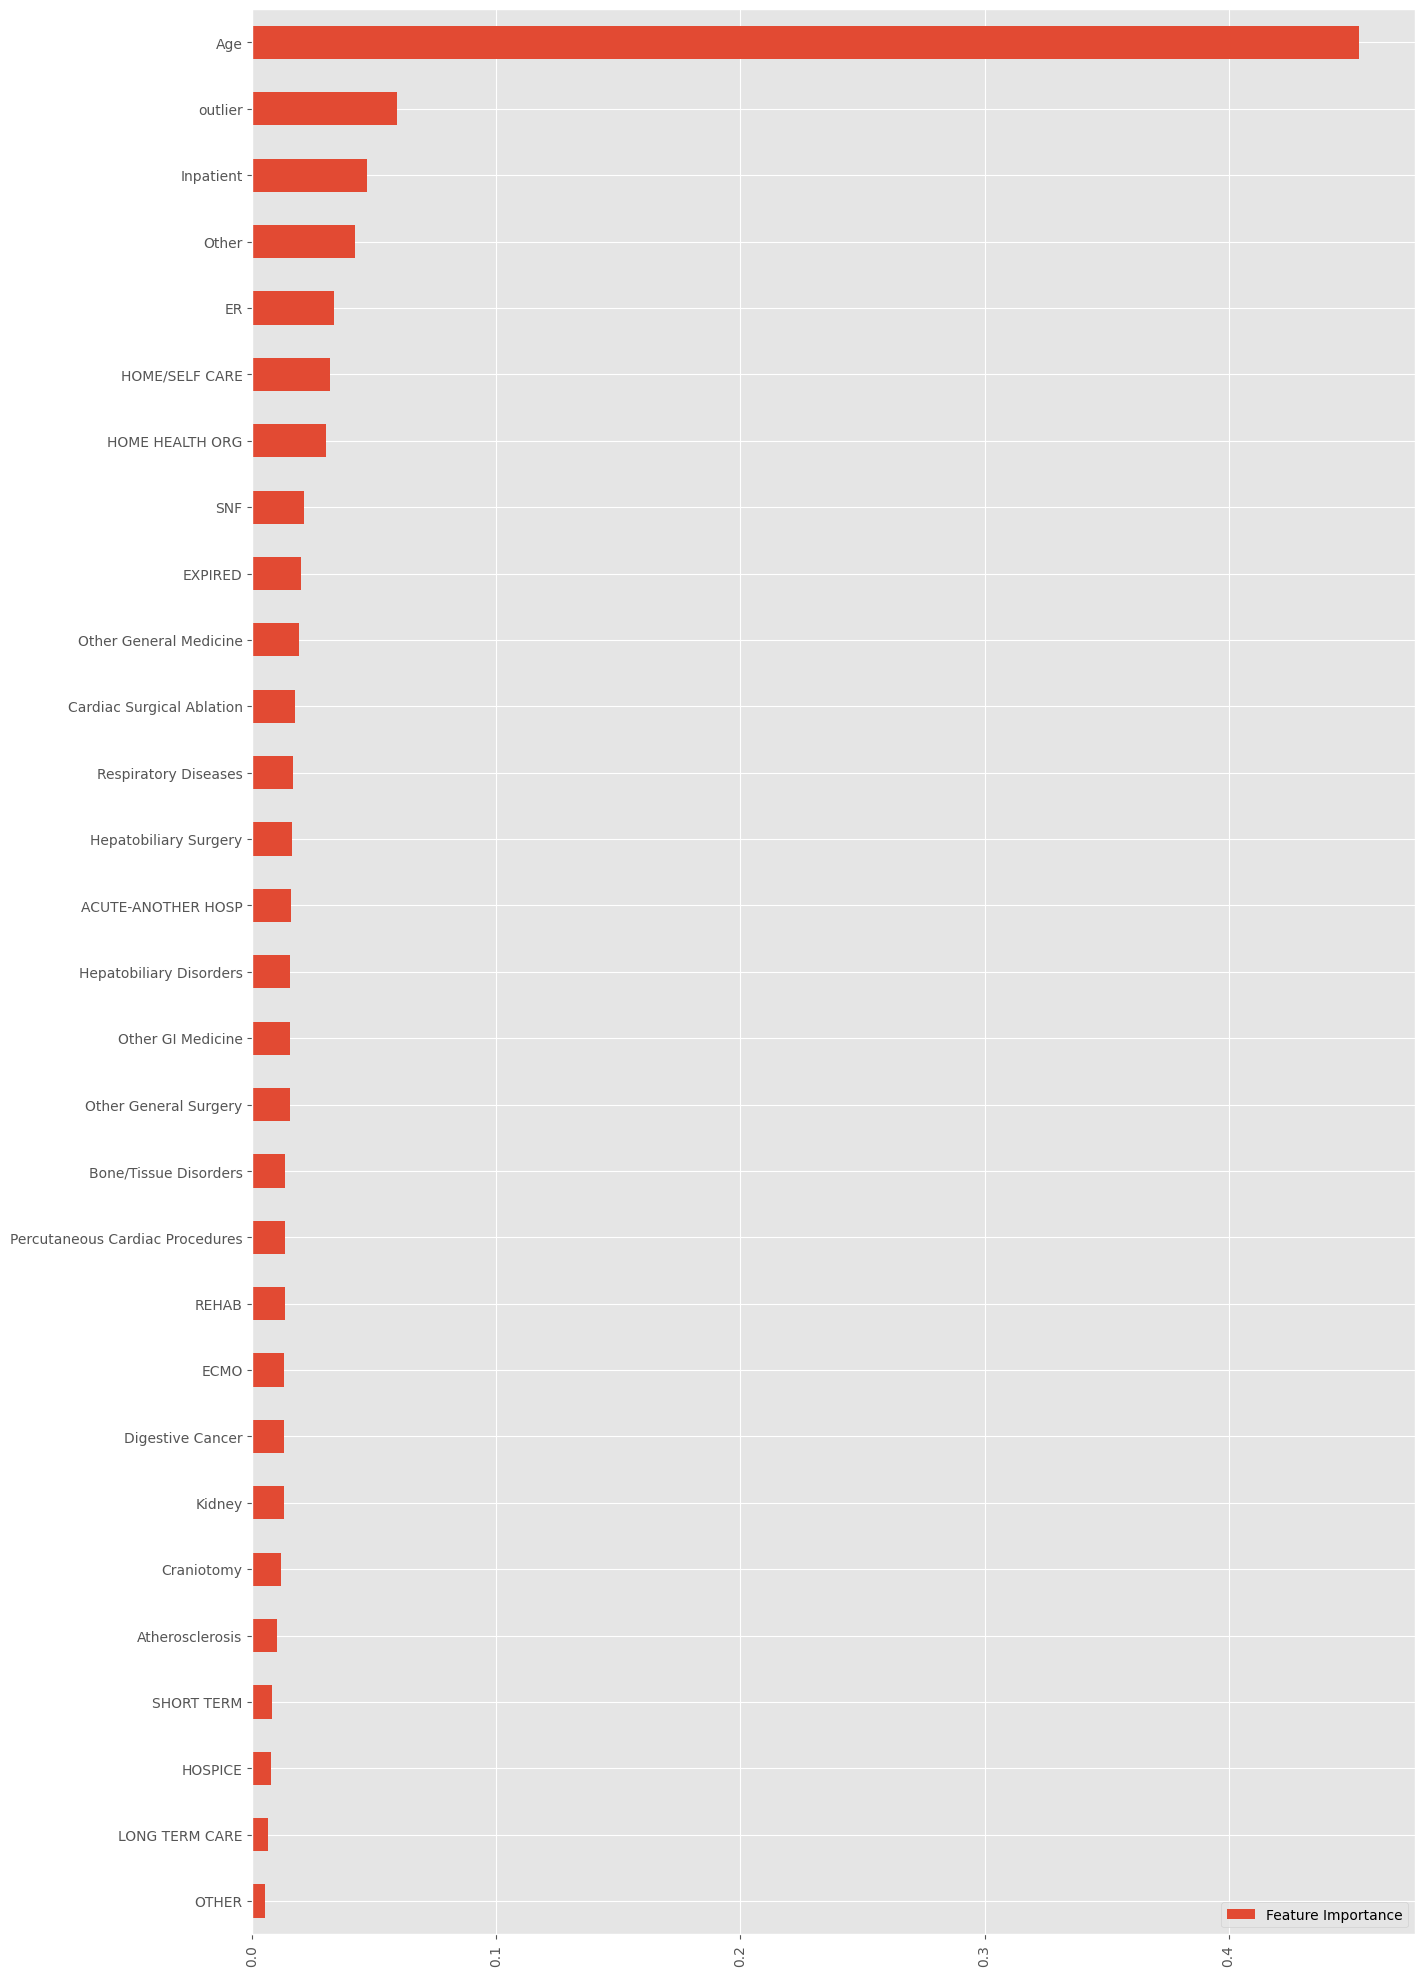

In [68]:
# FEATURE IMPORTANCE - NORMALIZED - last model

trainFinalFI = XNorm
yFinalFI = y

model.fit(trainFinalFI,yFinalFI)

FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model[FI_model["Feature Importance"] > 0.005].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.show()

In [69]:
# List of important features for model
FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model=FI_model.sort_values('Feature Importance', ascending = False)
print(FI_model[FI_model["Feature Importance"] > 0.001])

                                 Feature Importance
Age                                        0.453641
outlier                                    0.059143
Inpatient                                  0.046816
Other                                      0.042219
ER                                         0.033502
HOME/SELF CARE                             0.031741
HOME HEALTH ORG                            0.029981
SNF                                        0.021226
EXPIRED                                    0.019924
Other General Medicine                     0.019246
Cardiac Surgical Ablation                  0.017362
Respiratory Diseases                       0.016751
Hepatobiliary Surgery                      0.016320
ACUTE-ANOTHER HOSP                         0.015864
Hepatobiliary Disorders                    0.015563
Other GI Medicine                          0.015468
Other General Surgery                      0.015307
Bone/Tissue Disorders                      0.013450
Percutaneous

In [70]:
# Model fit and evaluation on test

final_predictions = model.predict(X_test)

#final_acc = accuracy(y_test, final_predictions)
# Confusion matrix

conf_mx = confusion_matrix(y_test, final_predictions)


Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [71]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print('Confusion Matrix:')
print(cm)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions, average='weighted')
recall = recall_score(y_test, final_predictions, average='weighted')
f1 = f1_score(y_test, final_predictions, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Confusion Matrix:
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# SGD

In [72]:
# Optimize hyper params for one model

SGDmodel = SGDClassifier()

param_grid = [{},]

grid_search = GridSearchCV(SGDmodel, param_grid, cv=5, scoring=scoring)
grid_search.fit(XNorm, y)

print(grid_search.best_estimator_)

SGDClassifier()


In [73]:
# Model fit and evaluation on test
trainFinalFI = XNorm
yFinalFI = y

SGDmodel.fit(trainFinalFI,yFinalFI)

SGD_pred = SGDmodel.predict(X_test)

#final_acc = accuracy(y_test, final_predictions)
# Confusion matrix

conf_mx = confusion_matrix(y_test, SGD_pred)

In [74]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, SGD_pred)
print('Confusion Matrix:')
print(cm)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, SGD_pred)
precision = precision_score(y_test, SGD_pred, average='weighted')
recall = recall_score(y_test, SGD_pred, average='weighted')
f1 = f1_score(y_test, SGD_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Confusion Matrix:
[[5 0 2 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 4 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0

# Decision Tree

In [75]:
# Optimize hyper params for one model

DTmodel = DecisionTreeClassifier()

param_grid = [{},]

grid_search = GridSearchCV(DTmodel, param_grid, cv=5, scoring=scoring)
grid_search.fit(XNorm, y)

print(grid_search.best_estimator_)

DecisionTreeClassifier()


In [76]:
# Model fit and evaluation on test
trainFinalFI = XNorm
yFinalFI = y

DTmodel.fit(trainFinalFI,yFinalFI)

DT_pred = DTmodel.predict(X_test)

#final_acc = accuracy(y_test, final_predictions)
# Confusion matrix

conf_mx = confusion_matrix(y_test, DT_pred)

In [77]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, DT_pred)
print('Confusion Matrix:')
print(cm)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, DT_pred)
precision = precision_score(y_test, DT_pred, average='weighted')
recall = recall_score(y_test, DT_pred, average='weighted')
f1 = f1_score(y_test, DT_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Confusion Matrix:
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# SVM

In [78]:
# Optimize hyper params for one model

SVMmodel = SVC(kernel='linear')

param_grid = [{},]

grid_search = GridSearchCV(SVMmodel, param_grid, cv=5, scoring=scoring)
grid_search.fit(XNorm, y)

print(grid_search.best_estimator_)

SVC(kernel='linear')


In [79]:
# Model fit and evaluation on test
trainFinalFI = XNorm
yFinalFI = y

SVMmodel.fit(trainFinalFI,yFinalFI)

SVM_pred = SVMmodel.predict(X_test)

#final_acc = accuracy(y_test, final_predictions)
# Confusion matrix

conf_mx = confusion_matrix(y_test, SVM_pred)

In [80]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, SVM_pred)
print('Confusion Matrix:')
print(cm)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, SVM_pred)
precision = precision_score(y_test, SVM_pred, average='weighted')
recall = recall_score(y_test, SVM_pred, average='weighted')
f1 = f1_score(y_test, SVM_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Confusion Matrix:
[[5 0 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 3 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 6 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 

In [81]:
def plot_confusion_matrix(cm,target_names,title='Confusion Matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

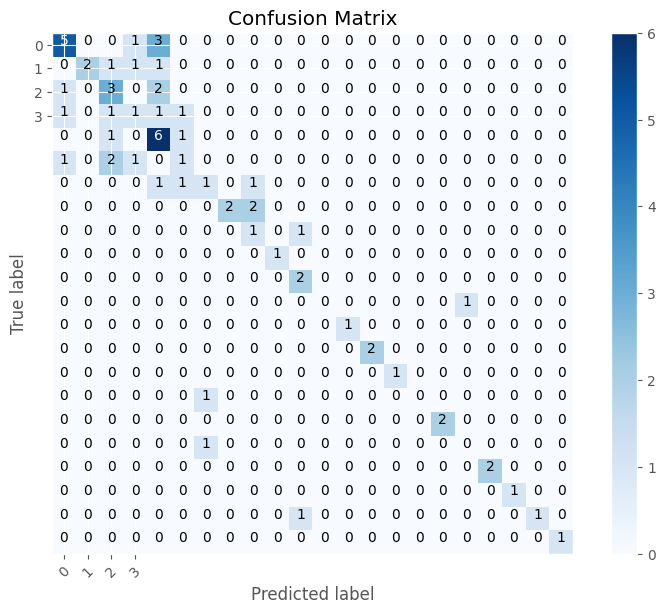

In [82]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = [0,1,2,3],
                      title        = "Confusion Matrix")

Class  0


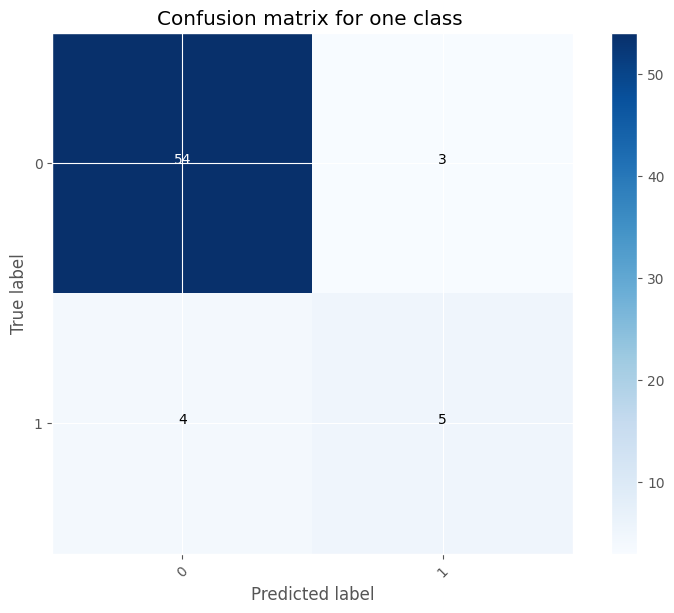

TPz  5
FNz  4
FPz  3
TNz  54
sum  66
[[54  3]
 [ 4  5]]
Sum of CM  66
accuracy  0.8939
recall  0.5556
precision  0.625
F1Score  0.5882
----------------------------------------
Class  1


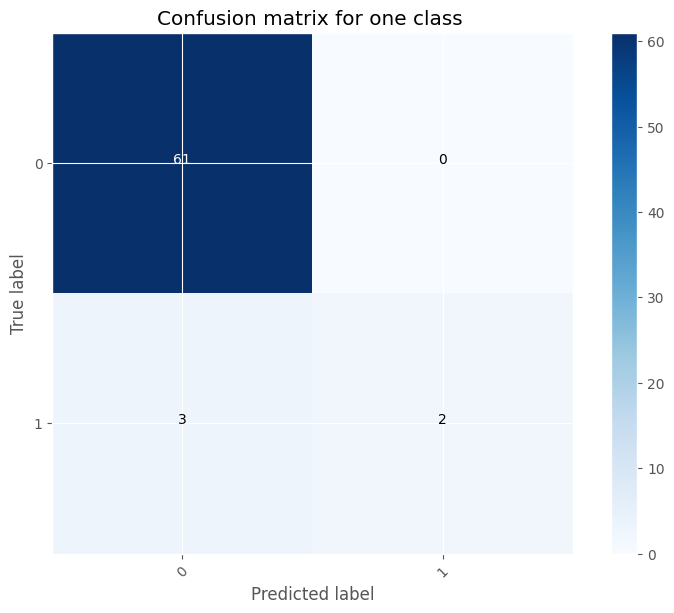

TPz  2
FNz  3
FPz  0
TNz  61
sum  66
[[61  0]
 [ 3  2]]
Sum of CM  66
accuracy  0.9545
recall  0.4
precision  1.0
F1Score  0.5714
----------------------------------------
Class  2


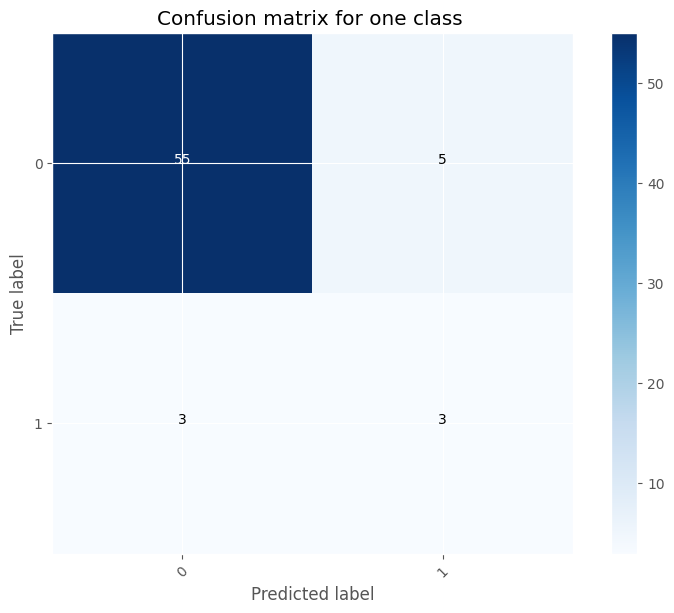

TPz  3
FNz  3
FPz  5
TNz  55
sum  66
[[55  5]
 [ 3  3]]
Sum of CM  66
accuracy  0.8788
recall  0.5
precision  0.375
F1Score  0.4286
----------------------------------------
Class  3


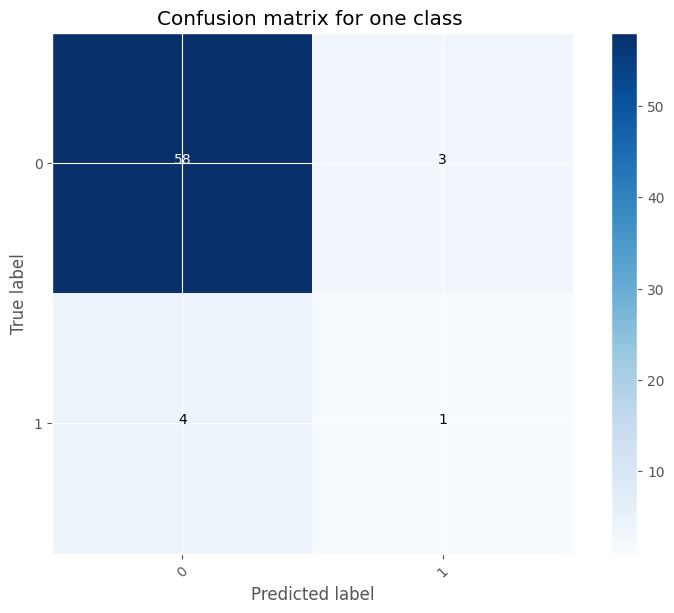

TPz  1
FNz  4
FPz  3
TNz  58
sum  66
[[58  3]
 [ 4  1]]
Sum of CM  66
accuracy  0.8939
recall  0.2
precision  0.25
F1Score  0.2222
----------------------------------------
TN:  228
FP:  11
FN:  14
TP:  11
________________________________________


In [83]:
# Confusion matrix and all metrics - for EACH class separately

NumClasses = 4

TP = 0
TN = 0
FP = 0
FN = 0

for z in range(NumClasses):
# One class at a time - calculate confusion matrix
    SumCM = np.sum(conf_mx)
    TPz = conf_mx[z,z]
    FNz = np.sum(conf_mx[z,:], axis=0) -TPz
    FPz = np.sum(conf_mx[:,z], axis=0) -TPz
    TNz = SumCM - (TPz+FNz+FPz)
    #FPz = np.sum(conf_mx[z], axis=-1) 
    #FPz = sum(conf_mx(:, z))-conf_mx(z, z)
    #FNz = sum(conf_mx(x, :), 2)-conf_mx(x, x)
    print('Class ',z)
  

    # Create conf matrix for class z
    cmZ = np.zeros([2, 2], dtype=np.int32)
    cmZ[0,0] = TNz
    cmZ[0,1] = FPz
    cmZ[1,0] = FNz
    cmZ[1,1] = TPz

    plot_confusion_matrix(cmZ, 
                          normalize    = False,
                          target_names = [0,1],
                          title        = "Confusion matrix for one class ")

    accuracy = (TPz+TNz)/(TPz+TNz+FPz+FNz)
    recall = TPz/(TPz+FNz)
    precision = TPz/(TPz+FPz)
    f1score = 2*recall*precision/(recall+precision)
    #roc_auc = auc(FPz, TPz)
    
    print('TPz ',TPz)
    print('FNz ',FNz)
    print('FPz ',FPz)
    print('TNz ',TNz)
    print('sum ', TPz+TNz+FPz+FNz)
    print(cmZ)
    print('Sum of CM ', np.sum(cmZ))
    print ('accuracy ',round(accuracy,4))
    print('recall ', round(recall,4))
    print('precision ', round(precision,4))
    print('F1Score ', round(f1score,4))
    print('-'*40)
    
    TP = TP + TPz
    TN = TN + TNz
    FP = FP + FPz
    FN = FN + FNz
print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)
print('_'*40)    

Confusion Matix for ALL Classes


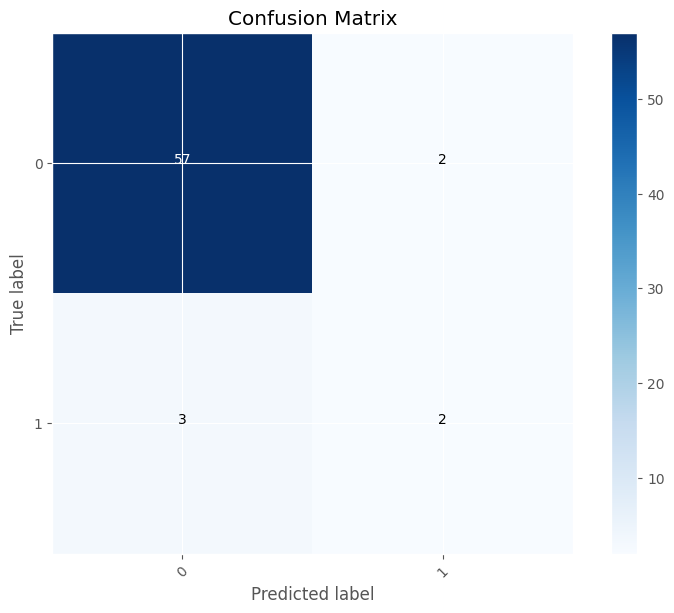

In [84]:
# Confusion Matrix for the WHOLE MODEL - ALL Classes

print('Confusion Matix for ALL Classes')

TP = TP / NumClasses
TN = TN / NumClasses
FP = FP / NumClasses
FN = FN / NumClasses


cm = np.zeros([2, 2], dtype=np.int32)
cm[0,0] = TN
cm[0,1] = FP
cm[1,0] = FN
cm[1,1] = TP

plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [0,1],
                      title        = "Confusion Matrix")

In [85]:
def multiclass_roc_auc_score(y_test, final_predictions, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(final_predictions)

    return roc_auc_score(y_test, y_pred, average=average)

print('AUC ROC ',multiclass_roc_auc_score(y_test, final_predictions))

AUC ROC  0.9939456035767512
